In [ ]:
!nvidia-smi

In [ ]:
!pip install diffusers==0.2.4
!pip install transformers scipy ftfy
!pip install "ipywidgets>=7,<8"

In [ ]:
#@title Enter you HuggingFace token

from google.colab import output
output.enable_custom_widget_manager()

fpath = '/usr/local/lib/python3.7/dist-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py'
with open(fpath, 'r') as f:
  text = f.read()

original_text = '''        # run safety checker
        safety_cheker_input = self.feature_extractor(self.numpy_to_pil(image), return_tensors="pt").to(self.device)
        image, has_nsfw_concept = self.safety_checker(images=image, clip_input=safety_cheker_input.pixel_values)
'''

new_text = '''        # run safety checker
        # safety_cheker_input = self.feature_extractor(self.numpy_to_pil(image), return_tensors="pt").to(self.device)
        # image, has_nsfw_concept = self.safety_checker(images=image, clip_input=safety_cheker_input.pixel_values)
        has_nsfw_concept = None
'''

text = text.replace(original_text, new_text)

with open(fpath, 'w') as f:
  f.write(text)

from huggingface_hub import notebook_login

notebook_login()

In [4]:
#@title SD initialization

import torch
from diffusers import StableDiffusionPipeline

model_type = 'WIFU'
if model_type == 'ORIGINAL':
  #ORIGINAL
  # make sure you're logged in with `huggingface-cli login`
  pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4", revision="fp16", torch_dtype=torch.float16, use_auth_token=True)  

elif model_type == 'WIFU':
  # WIFU 
  model_id = "hakurei/waifu-diffusion"
  pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16, revision='fp16')

pipe = pipe.to("cuda")

Downloading:   0%|          | 0.00/1.34k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.30k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/342 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/543 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.64k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/608M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/288 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/586 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/246M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/525k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/472 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/802 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/786 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.72G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/564 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/167M [00:00<?, ?B/s]

Seed: 4196600288


0it [00:00, ?it/s]

HEX COLORS: 
['#96a9ae', '#20101d', '#d3b5ae', '#73445f', '#fafbfb']


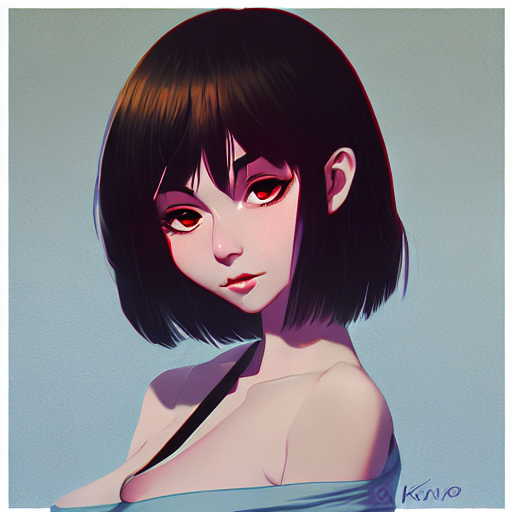

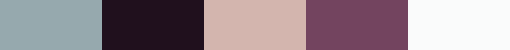

In [12]:
#@title Generate pallete

import random
from torch import autocast
from IPython.display import display
from math import sqrt
import pandas as pd
import numpy as np

import random
try:
  import Image
except ImportError:
  from PIL import Image


class Point:
  
  def __init__(self, coordinates):
    self.coordinates = coordinates

class Cluster:
  
  def __init__(self, center, points):
    self.center = center
    self.points = points

class KMeans:
  
  def __init__(self, n_clusters, min_diff = 1):
    self.n_clusters = n_clusters
    self.min_diff = min_diff
    
  def calculate_center(self, points):    
    n_dim = len(points[0].coordinates)    
    vals = [0.0 for i in range(n_dim)]    
    for p in points:
      for i in range(n_dim):
        vals[i] += p.coordinates[i]
    coords = [(v / len(points)) for v in vals]    
    return Point(coords)
  
  def assign_points(self, clusters, points):
    plists = [[] for i in range(self.n_clusters)]

    for p in points:
      smallest_distance = float('inf')

      for i in range(self.n_clusters):
        distance = euclidean(p, clusters[i].center)
        if distance < smallest_distance:
          smallest_distance = distance
          idx = i

      plists[idx].append(p)
    
    return plists
    
  def fit(self, points):
    clusters = [Cluster(center=p, points=[p]) for p in random.sample(points, self.n_clusters)]
    
    while True:

      plists = self.assign_points(clusters, points)

      diff = 0

      for i in range(self.n_clusters):
        if not plists[i]:
          continue
        old = clusters[i]
        center = self.calculate_center(plists[i])
        new = Cluster(center, plists[i])
        clusters[i] = new
        diff = max(diff, euclidean(old.center, new.center))

      if diff < self.min_diff:
        break

    return clusters


def euclidean(p, q):
  n_dim = len(p.coordinates)
  return sqrt(sum([
      (p.coordinates[i] - q.coordinates[i]) ** 2 for i in range(n_dim)
  ]))

def get_points(image_path):  
  img = Image.open(image_path)
  img.thumbnail((200, 400))
  img = img.convert("RGB")
  w, h = img.size
  
  points = []
  for count, color in img.getcolors(w * h):
    for _ in range(count):
      points.append(Point(color))
    
  return points

def rgb_to_hex(rgb):
  return '#%s' % ''.join(('%02x' % p for p in rgb))

def get_colors(filename, n_colors=3):
  points = get_points(filename)
  clusters = KMeans(n_clusters=n_colors).fit(points)
  clusters.sort(key=lambda c: len(c.points), reverse = True)
#   rgbs = [map(int, c.center.coordinates) for c in clusters]
  rgbs = [[int(_) for _ in c.center.coordinates] for c in clusters]
  return list(map(rgb_to_hex, rgbs)), rgbs


#######################
prompt_text = 'by Ilya Kuvshinov' #@param {type:"string"}
number_of_colors = 5 #@param {type:"integer"}
save_pallete_to_file = True #@param {type:"boolean"}
show_squared_pallete = False #@param {type:"boolean"}

#@markdown Additional parameters
guidance_scale = 10.0 #@param {type:"number"}
num_inference_steps = 150 #@param {type:"integer"}
width = 512 #@param {type:"integer"}
height = 512 #@param {type:"integer"}
#######################




num_cols = 1




prompt2 = [prompt_text] * num_cols
seed2 = random.randint(0, 2**32)
fname = f'/content/{seed2}.jpg'
# seed = 611370552

COL_NUMBER = 0 #<--------!!! 

generator = torch.Generator("cuda").manual_seed(seed2)
print(f'Seed: {seed2}')

with autocast("cuda"):
  images = pipe(prompt2, num_inference_steps=num_inference_steps, height=height, width=width, generator=generator, guidance_scale=guidance_scale)["sample"] #STEPS AND SIZE
  image = images[COL_NUMBER]

image.save(fname, quality=95)

colors, rgbs = get_colors(fname, n_colors=number_of_colors)


def display_pal_sq(
         w=50, h=50, save_to_file=save_pallete_to_file, filename=f"{seed2}_color_palette", extension="jpg"
    ):
        img = Image.new("RGB", size=(w * number_of_colors, h))
        arr = np.asarray(img).copy()
        for i in range(number_of_colors):
            c = rgbs[i]
            arr[:, i * h : (i + 1) * h, :] = c
        img = Image.fromarray(arr, "RGB")
        img.show()
        if save_to_file:
            img.save(f"{filename}_sq.{extension}")
        return img

def display_pal(
         w=int(width/number_of_colors), h=50, save_to_file=save_pallete_to_file, filename=f"{seed2}_color_palette", extension="jpg"
    ):

        img = Image.new("RGB", size=(w * number_of_colors, h))
        arr = np.asarray(img).copy()
        for i in range(number_of_colors):
            arr[:, i * w : (i + 1) * w, :] = rgbs[i]
        img = Image.fromarray(arr, "RGB")
        img.show()
        if save_to_file:
            img.save(f"{filename}.{extension}")
        return img

print(f'HEX COLORS: \n{colors}')
img = display_pal()
img2 = display_pal_sq()
if not show_squared_pallete:
  display(image, img)
else:
  display(image, img2)